In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [281]:
sADF=pd.read_csv(r"C:\Users\Hasib\OneDrive - University of Calgary\PIMS M2PI Workshop 2022\Novion GI\Site A - Tue Feb 15 2022 to Thu Jun 30 2022.csv")
sBDF=pd.read_csv(r"C:\Users\Hasib\OneDrive - University of Calgary\PIMS M2PI Workshop 2022\Novion GI\Site B - Tue Feb 15 2022 to Thu Jun 30 2022.csv")

In [282]:
#sADF.head()

In [283]:
#print(sADF.shape,sBDF.shape)

In [284]:
#print(sADF.columns,sBDF.columns)

In [285]:
pd.to_datetime(sADF["Timestamp"]);
pd.to_datetime(sBDF["Timestamp"]);

In [300]:
wl_mm=sADF[" Water Level [m]"].to_numpy()*1000  # water level in mm
slope_up=[]
slope_dw=[]
for i in range(sADF.shape[0]-4):
    slope_dw.append((wl_mm[i+4]-wl_mm[i])/(4*5))
    slope_up.append((wl_mm[i+1]-wl_mm[i])/(2*5))

(array([1.4000e+01, 5.8000e+01, 6.8900e+02, 3.7641e+04, 3.6400e+02,
        1.1800e+02, 2.7000e+01, 1.2000e+01, 1.4000e+01, 1.0000e+01]),
 array([-26.65, -18.76, -10.87,  -2.98,   4.91,  12.8 ,  20.69,  28.58,
         36.47,  44.36,  52.25]),
 <a list of 10 Patch objects>)

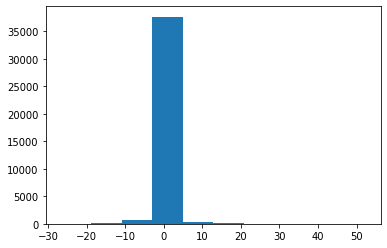

In [301]:
plt.hist(slope_dw)


(array([5.0000e+00, 4.9000e+01, 3.8724e+04, 1.4400e+02, 1.6000e+01,
        5.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-32.4 , -19.35,  -6.3 ,   6.75,  19.8 ,  32.85,  45.9 ,  58.95,
         72.  ,  85.05,  98.1 ]),
 <a list of 10 Patch objects>)

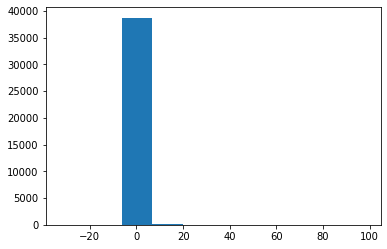

In [302]:
plt.hist(slope_up)

In [416]:
def IdentifyEvents_2(df,tol_up,tol_dw):
    #  This method compare slope for start and end of an event
    # For the start of an event we want the slope to be very big +ve value (steep tangent with +ve slope)
    # To detect the end of an event we want the slope to be very small -ve value (flat tangent with -ve slope)
    wlc_mm=np.diff(df[" Water Level [m]"])*1000 # water level change measured in mm
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    nre=True
    # rpc=0
    dpc=0
    start_time=[]
    end_time=[]
    start_index=[]
    end_index=[]
    duration=[]
    for i in range (df.shape[0]-3):
        
        if nre==True:
            rpc=0    # duration of rainfall set to zero
            # calculating the slope (mm/min) at index i
            slope_1=(wl_mm[i+1]-wl_mm[i])/(5)   # forwward difference formula
            
            if slope_1>tol_up:
                # This is a new rainfall event
                # print("A new rainfall started at time :",df["Timestamp"][i]," with index position :",i)
                start_time.append(df["Timestamp"][i])
                start_index.append(i)
                dpc=0     # Dry period count initialization
                rpc+=1      # count the duration of rainfall
                nre=False
        else:
            # calculating the slope (mm/min) at index i+1
            slope_2=(wl_mm[i+4]-wl_mm[i])/(4*5)  # average slope of 4 consecutive time steps
            der_2nd=(wl_mm[i]-wl_mm[i-1]+wl_mm[i-2])/(5**2)
            if slope_2>tol_dw and der_2nd>0: 
                dpc+=1
                skip=5*(5*12)    # 5 hours of no significant change in water level means start of another event
                # save this date 
                if dpc>skip-4:
                    nre=True
                    end_time.append(df["Timestamp"][i+4-skip])
                    end_index.append(i+4-skip)
                    duration.append(rpc-skip+4)
                    #print(f"Rainfall event ended at time :",df["Timestamp"][i-72]," with index position :",i-72,"\nDuration of this rainfall period was :",rpc-72)
                    #print("Now it is a dry period of more than 6 hours")
                else:
                    rpc+=1    # count the duration of rainfall
            else:
                dpc=0
                rpc+=1
    return start_time,end_time,start_index,end_index,duration,wl_mm

In [417]:
start_timeA,end_timeA,start_indexA,end_indexA,rf_durationA,water_levelA=IdentifyEvents_2(sADF,12,-0.6)
rf_eventA=pd.DataFrame({"Rainfall_start_time":start_timeA,"Rainfall_end_time":end_timeA,"Rainfall_start_index":start_indexA,"Rainfall_end_index":end_indexA,"Rainfall_duration":rf_durationA})
rf_eventA

,Rainfall_start_time,Rainfall_end_time,Rainfall_start_index,Rainfall_end_index,Rainfall_duration
0,2022-02-19 11:30:00 a.m.,2022-02-19 11:15:00 p.m.,1085,1226,141
1,2022-02-21 3:55:00 a.m.,2022-02-21 8:20:00 a.m.,1570,1623,53
2,2022-02-26 5:25:00 p.m.,2022-03-02 9:00:00 p.m.,3172,4367,1195
3,2022-03-11 8:55:00 p.m.,2022-03-15 8:05:00 p.m.,6958,8088,1130
4,2022-03-17 7:00:00 a.m.,2022-03-19 11:45:00 a.m.,8507,9140,633
5,2022-03-20 2:25:00 p.m.,2022-03-23 5:50:00 p.m.,9460,10365,905
6,2022-03-26 5:05:00 a.m.,2022-03-28 12:45:00 p.m.,11076,11744,668
7,2022-04-03 3:25:00 p.m.,2022-04-04 6:45:00 a.m.,13504,13688,184
8,2022-04-08 1:30:00 a.m.,2022-04-08 3:40:00 a.m.,14777,14803,26
9,2022-04-12 10:50:00 a.m.,2022-04-12 6:25:00 p.m.,16041,16132,91


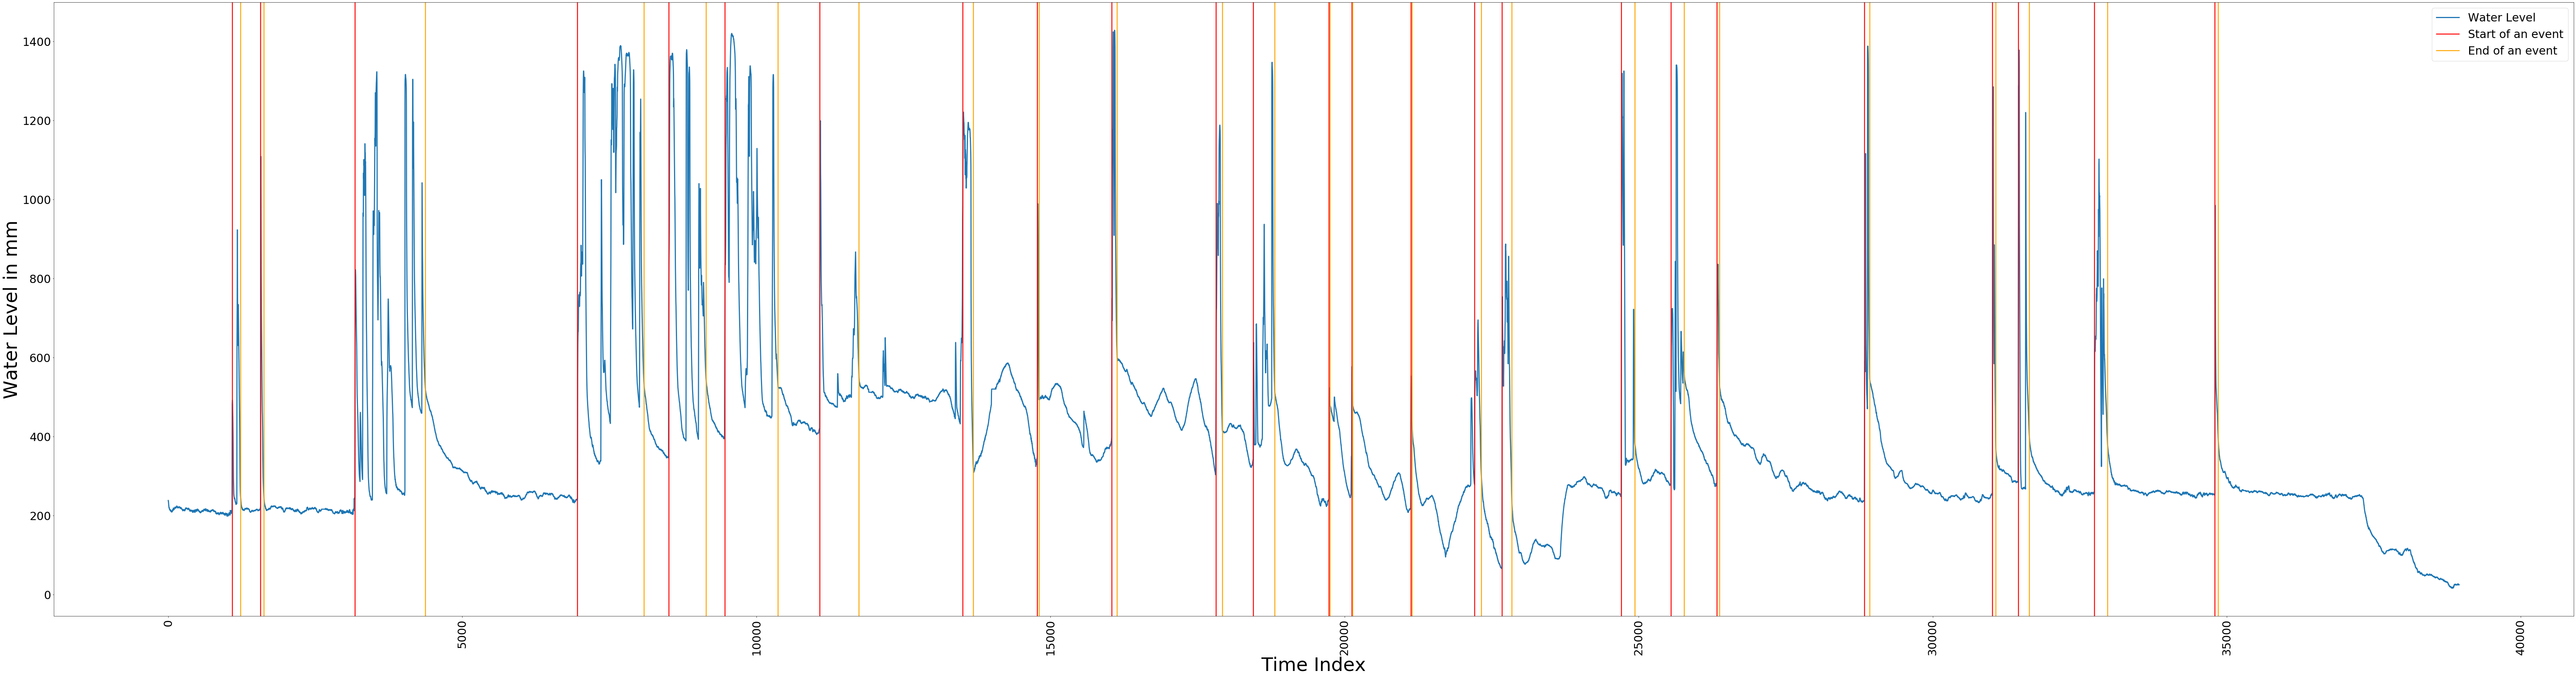

In [483]:
plt.figure(figsize=(120, 30))
wle,=plt.plot(water_levelA,label='Water Level',linewidth=3)
for i in start_indexA:
    st=plt.axvline(x=i, linewidth=2.5,color='r',label="Start of an event")
for i in end_indexA:
    en=plt.axvline(x=i,linewidth=2.5, color='orange',label="End of an event")
plt.xlabel('Time Index',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',handles=[wle,st,en],fontsize=30)
plt.show()

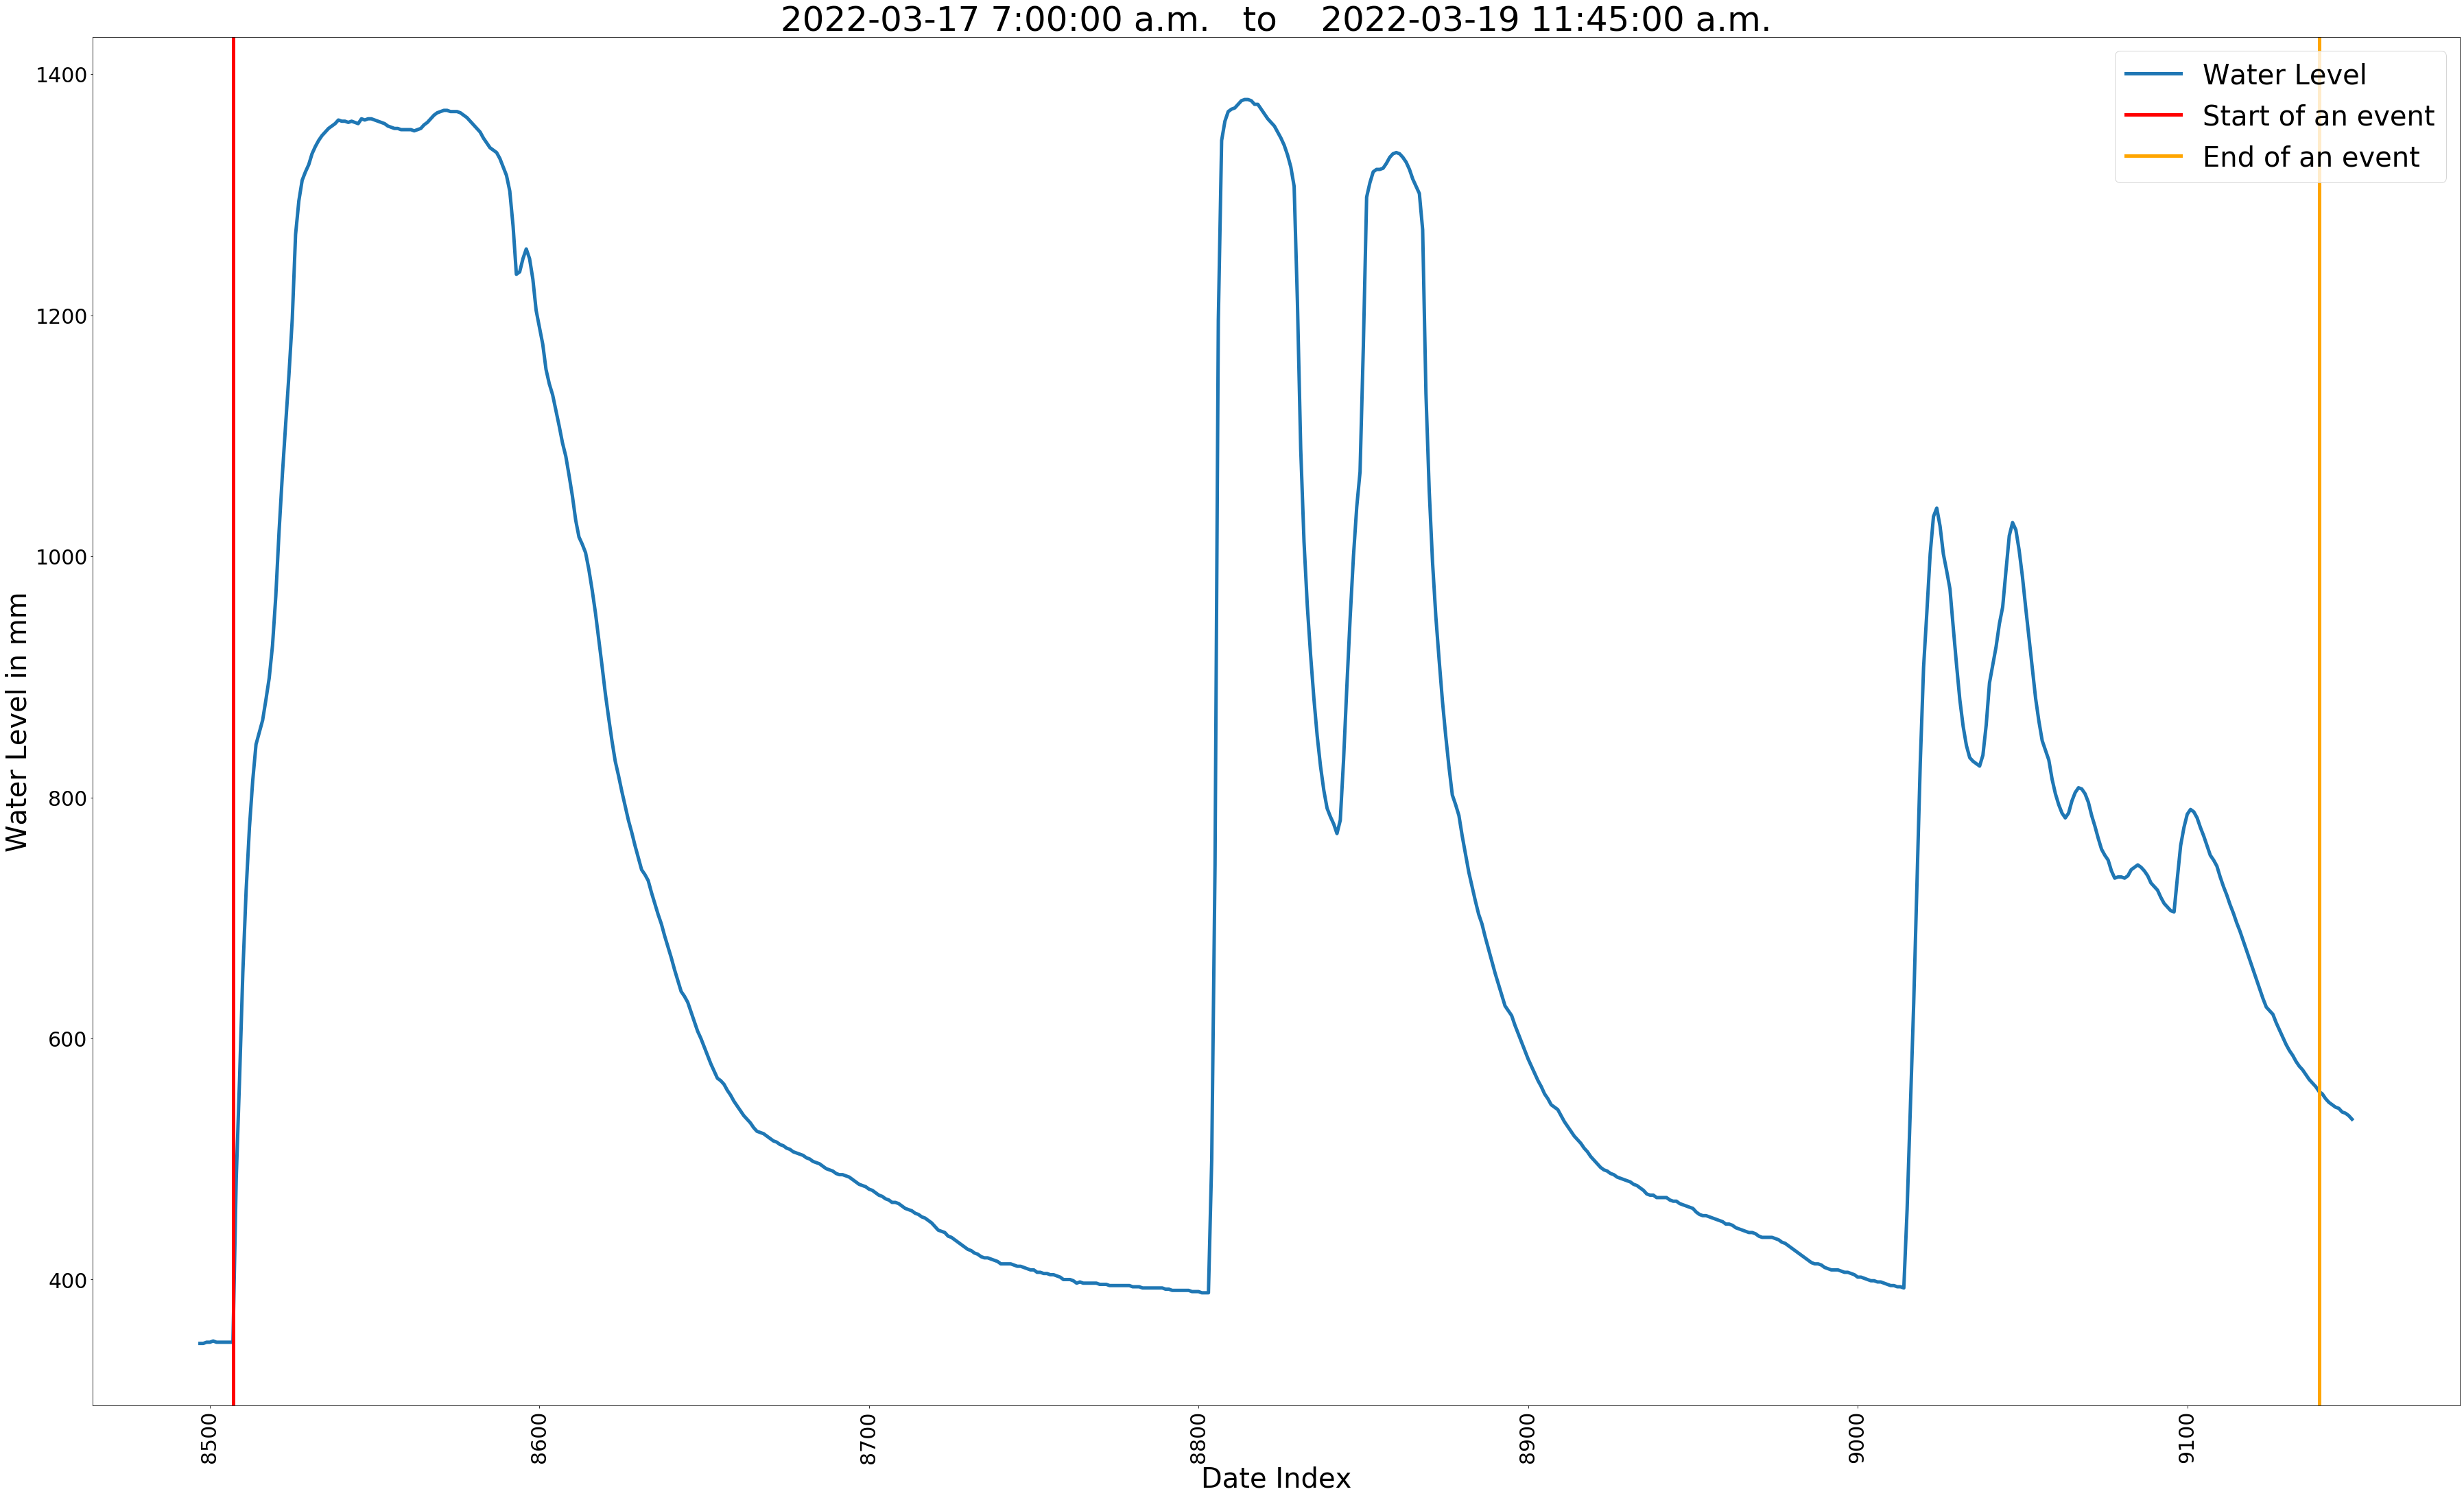

In [478]:
# Let's see a particular !Rainfall event
buffer=10
index=4
#X=Timestamp[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer+1]
X=range(start_indexA[index]-buffer,end_indexA[index]+buffer+1)
Y=wl_mm[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer+1]
plt.figure(figsize=(50, 30))
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_indexA[index],linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_indexA[index],linewidth=5, color='orange',label="End of an event")
plt.title('Rainfall Event')
plt.xlabel('Date Index',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)
plt.tight_layout()
plt.title(start_timeA[index]+"   to    "+end_timeA[index],fontsize=50)
plt.show()

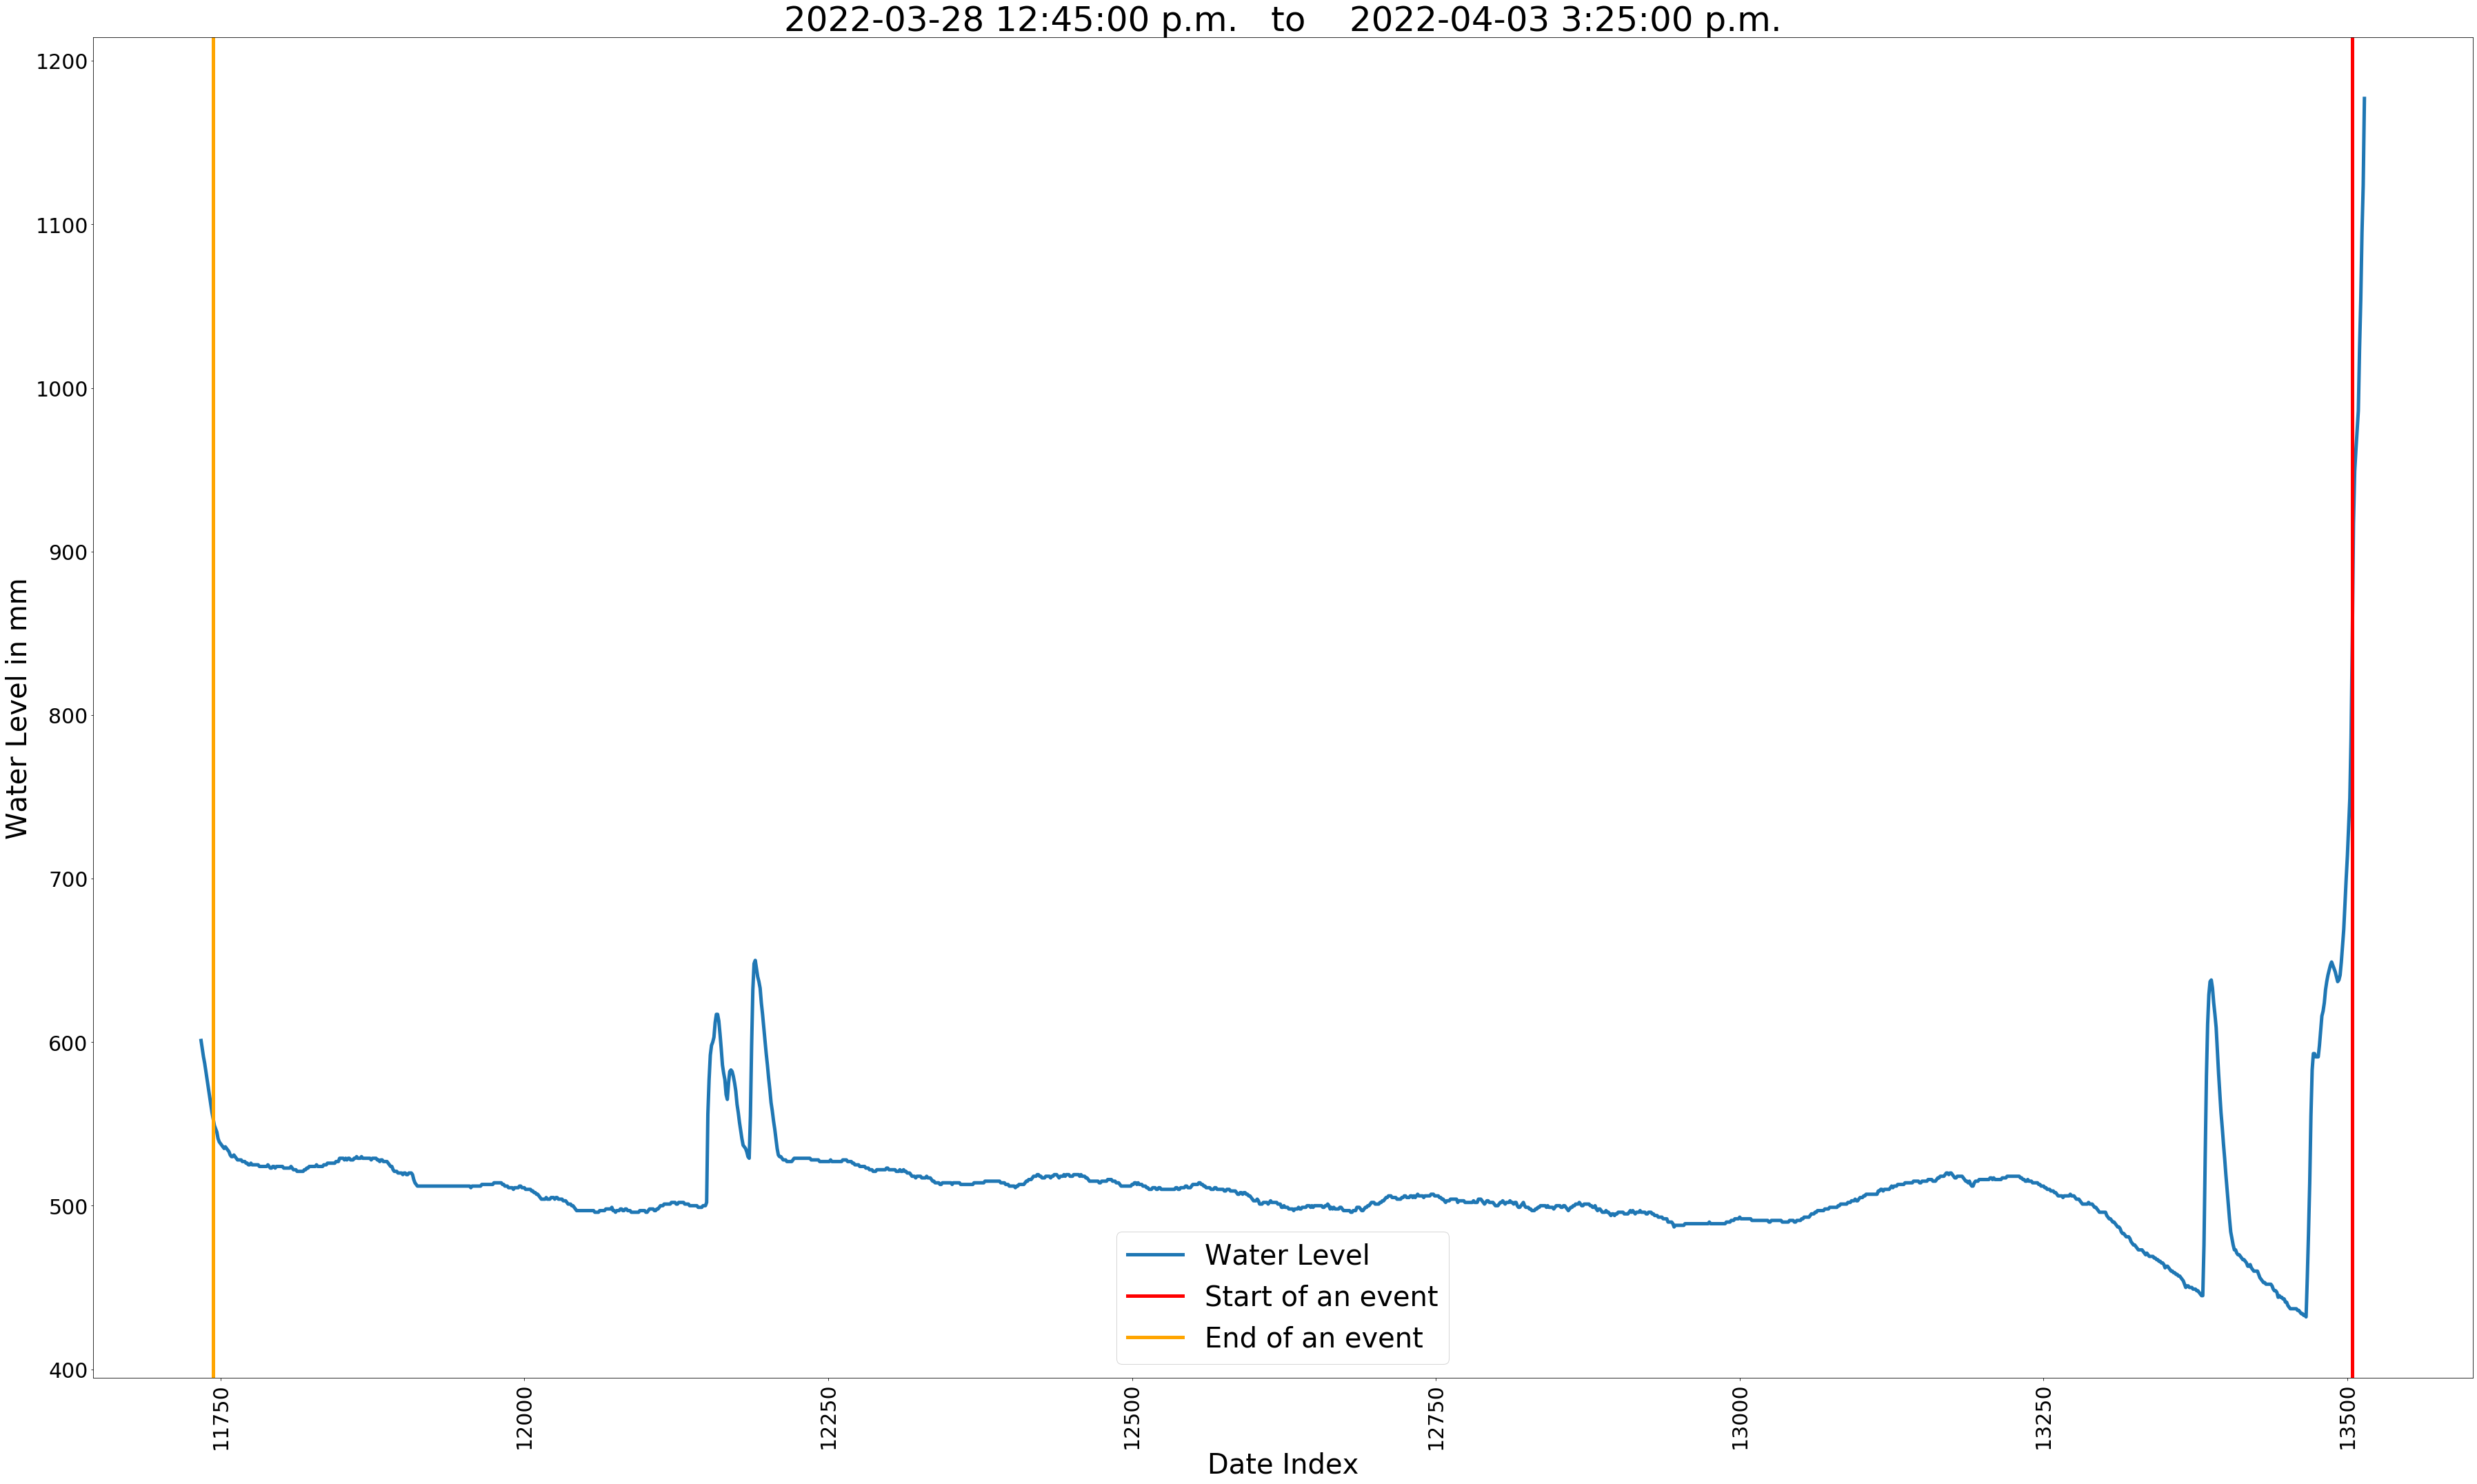

In [479]:
# Let's look at a particular No !Rainfall event
buffer=10
index=7
X=range(end_indexA[index-1]-buffer,start_indexA[index]+buffer+1)
Y=wl_mm[rf_eventA["Rainfall_end_index"][index-1]-buffer:rf_eventA["Rainfall_start_index"][index]+buffer+1]
plt.figure(figsize=(50, 30))
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_indexA[index], linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_indexA[index-1],linewidth=5, color='orange',label="End of an event")
plt.title('No Rainfall Event')
plt.xlabel('Date Index',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)
plt.title(end_timeA[index-1]+"   to    "+start_timeA[index],fontsize=50)
plt.tight_layout()
plt.show()